### IDEA

1. 用田調課格式儲存的docx.檔，提取出知本卑南語語料transcription
2. 為其建立Fasttext word embeddings
3. 再利用 PCA降維度、K-means cluster analysis 看卑南語料的詞類分布狀況

### setting

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

In [2]:
import os
os.chdir('')

In [3]:
import pandas as pd
import numpy as np
import re
import json

In [ ]:
!pip install python-docx

### Extract transciptions from .docx files

In [ ]:
DOCX_DIR = 'My Directory of Word Documents'

Contents in 1 docx

In [23]:
from docx import Document
filename = DOCX_DIR+'/2022030702.docx'
document = Document(filename)

fullText = []
for paragraph in document.paragraphs:
    fullText.append(paragraph.text)

for t in fullText[:30]:
    print(t)

File name: 20220307
Language: Puyuma
Dialect: Katratripulr
Speaker: 陳金妹, Ukesang Mavaliw, Female, 1950
Collected: 2022-03-07
Revised: 2022-04-25
Transcribed by: 陳品而

1. 
patatakesi ku i Katratridpulr kana palrivak na takesiyan
pata-takesi=ku          	i     	Katratridpulr  	kana     	palrivak    
PRS-teach=1SG.NOM		LOC		Katratridpulr	OBL.DEF 	initial	  	
現在-教書=1SG.主格  	處格  	知本(地名)  	斜格.限定 	初期(小學) 

na      	takesi-yan 
L		teach-place
連繫詞	學校-場所

#e I teach in Zhiben elementary school.
#c 我在知本國小教書。
#n 知本也可以簡寫成katridpulr　

2. 
a temakakesi ku
a 	  t<em>a<ka>kesi=ku
NOM  <AF><STAT>read.book=1SG.NOM
主格   <主焦><狀態>讀冊=1SG.主格

#e I am a student.
#c 我是學生


In [38]:
# get all docx files
docx_filenames = []
for filename in os.listdir('DOCX_DIR'):
    m = re.match('20220[\d]+\.docx', filename)
    if m:
        docx_filenames.append(filename)

len(docx_filenames),docx_filenames[:3]

(17, ['2022030702.docx', '2022031402.docx', '2022032102.docx'])

In [84]:
def extract_transcription(fullText):

    puyumas = []

    for i in range(len(fullText)):
        m = re.match('[\d]+\.', fullText[i])
        if m:         
            text = fullText[i+1].strip()
            if '=' not in text and '-' not in text:
                if not re.search('[\u4e00-\u9fa5]',text):
                    puyumas.append(text)
    
    return puyumas

In [85]:
# build puyuma text dict
fullText_dict = {}
all_puyumas = []

for filename in docx_filenames:
    file = f'{DOCX_DIR}/'+filename
    
    # read raw text
    document = Document(file)
    fullText = []
    for paragraph in document.paragraphs:
            fullText.append(paragraph.text)

    fullText_dict[filename] = fullText
    puyumas = extract_transcription(fullText)
    all_puyumas = all_puyumas + puyumas

all_puyumas[:3]

['patatakesi\xa0ku i Katratridpulr kana palrivak na takesiyan',
 'a temakakesi ku',
 'a muwauma ku']

### Pre-process texts

clean and tokenize

In [86]:
text_cleaning_re = "\?|\!|？|！|\.|,|\d|=|-|<|>"

def clean(text, cleaning_re):
  text = re.sub(cleaning_re, '', str(text))
  return text

In [92]:
# 小寫 斷詞
def tokenize(texts):
  lists_of_list = []
  for text in texts:
    text = text.split()
    lists_of_list.append(text)

  return lists_of_list

In [93]:
# 遍歷句子
## clean
puyuma_cleaned = []
for text in all_puyumas:
  puyuma_cleaned.append(clean(text,text_cleaning_re))

puyuma_cleaned = list(set(puyuma_cleaned))

## tokenize
puyuma_seg = tokenize(puyuma_cleaned)
print(len(puyuma_cleaned),len(puyuma_seg))

202 202


In [95]:
puyuma_cleaned[:2],puyuma_seg[:2]

(["tremima' ku za vulraw kana sinsi", "ku trima'anay na vulraw i ciba"],
 [["tremima'", 'ku', 'za', 'vulraw', 'kana', 'sinsi'],
  ['ku', "trima'anay", 'na', 'vulraw', 'i', 'ciba']])

### Fasttext Model

Build Fasttext model

In [97]:
from gensim.models import FastText

ft_corpus = puyuma_seg

In [107]:
# define fastText model
ft_model = FastText(size = 8,
                    window = 5,
                    min_count = 3,
                    workers = 4,
                    batch_words = 1000)

ft_model.build_vocab(ft_corpus)

In [108]:
ft_model.train(ft_corpus, total_examples=len(ft_corpus), epochs = 32)
wordindex = ft_model.wv.index2word

(88, ['i', 'na', 'ku'])

In [109]:
print(len(ft_model.wv.vocab))

88


In [110]:
print(ft_model.wv['kana']) # 斜格.限定(OBL.DEF)

[-0.7367697  -0.3411667  -1.1449195   0.52359605 -1.8950329   1.3685256
  0.23091303 -0.31209624]


In [113]:
ft_model.save("./ft8.model")
# model = FastText.load("ft.model")

In [114]:
# embedding matrix
cols = list(range(0,8))
vec_matrix = pd.DataFrame(columns=cols)

for i in range(len(wordindex)):
  word = wordindex[i]
  new = pd.DataFrame(ft_model.wv[word].reshape(1,-1), columns=cols, index=[word])

  vec_matrix = pd.concat([vec_matrix,new])

In [115]:
vec_matrix

,0,1,2,3,4,5,6,7
i,-0.663688,-0.196734,-0.983238,0.384399,-1.683407,1.146840,0.178836,-0.229177
na,-0.638302,-0.320899,-0.924823,0.423185,-1.531257,1.126337,0.095160,-0.301295
ku,-0.458272,-0.167820,-0.676139,0.262518,-1.026465,0.784802,0.130497,-0.119062
za,-0.466391,-0.145508,-0.677054,0.211915,-1.058414,0.712317,0.060968,-0.134991
tu,-0.478757,-0.228891,-0.737553,0.340511,-1.211962,0.973637,0.121490,-0.177271
...,...,...,...,...,...,...,...,...
verayanay,-0.314286,-0.142488,-0.460484,0.200720,-0.733370,0.565683,0.088383,-0.127359
siyaw,-0.457059,-0.215317,-0.671148,0.310804,-1.135486,0.859773,0.148098,-0.198743
muranak,-0.363136,-0.132823,-0.529782,0.221296,-0.880578,0.621279,0.127481,-0.123242
amanan,-0.257614,-0.120542,-0.417777,0.177710,-0.612074,0.463396,0.060395,-0.104610


### PCA

In [117]:
'PCA'
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

std_df = StandardScaler().fit_transform(vec_matrix) 


pca = PCA(n_components=8)
pca_fitted = pca.fit_transform(std_df)

# 存成df
PCA_components = pd.DataFrame(pca_fitted)

([<matplotlib.axis.XTick at 0x7f5fc579a670>,
 <a list of 8 Text major ticklabel objects>)

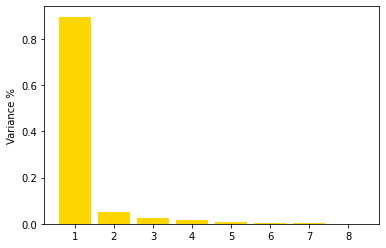

In [118]:
# plot 變異數
PC = range(1, pca.n_components_+1)

plt.bar(PC, pca.explained_variance_ratio_, color='gold')
plt.ylabel('Variance %')
plt.xticks(PC)

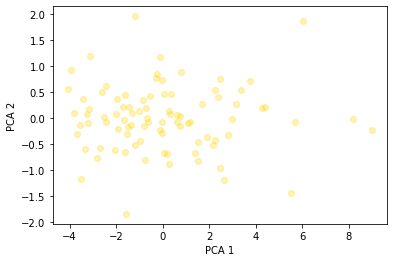

In [119]:
# plot pca 數據

plt.scatter(PCA_components[0], PCA_components[1], alpha=.3, color='gold')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

### KMeans

KMeans

In [124]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=5)
model.fit(PCA_components.iloc[:,:2])

labels = model.predict(PCA_components.iloc[:,:2])

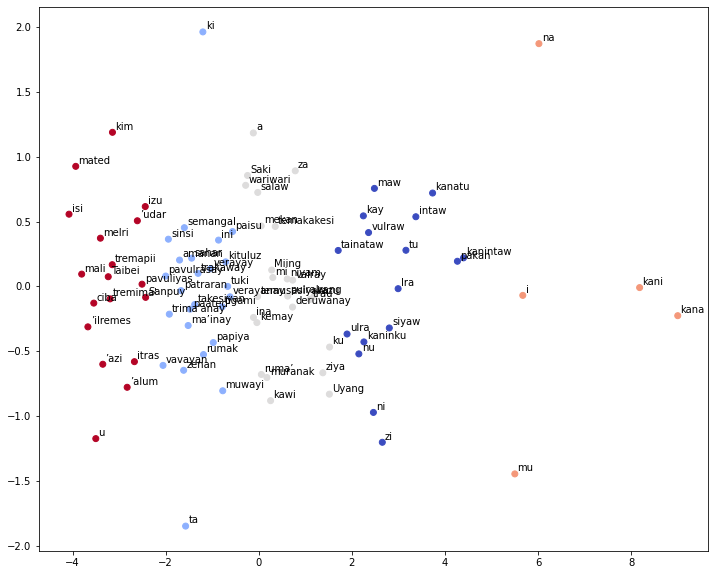

In [129]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12, 10))
plt.scatter(PCA_components[0], PCA_components[1], c=labels, cmap='coolwarm')

offset =70
for i,row in PCA_components.iterrows():
  plt.annotate(wordindex[i], xy=(PCA_components.iloc[i,0]+0.06,PCA_components.iloc[i,1]+0.02))

plt.show()